In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage import io, color, exposure, transform
from sklearn.model_selection import train_test_split
import os
import glob
import h5py

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.optimizers import SGD
from keras import backend as K
K.set_image_data_format('channels_first')

from matplotlib import pyplot as plt
%matplotlib inline

NUM_CLASSES = 43
IMG_SIZE = 48

In [3]:
# 이미지 사전작업 - training 안의 이미지들을 가져올 때 동일한 크기로 만들기 위해 사용
def preprocess_img(img):
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1)

    return img

def get_class(img_path):
    return int(img_path.split('/')[-2])

In [ ]:
# training 이미지를 X_train, y_train으로 가져오기
root_dir = '/content/drive/MyDrive/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images'
imgs = []
labels = []

all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    img = preprocess_img(io.imread(img_path))
    label = get_class(img_path)
    if len(imgs)%1000 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
    imgs.append(img)
    labels.append(label)

X_train = np.array(imgs, dtype='float32')
# Make one hot targets
y_train = np.eye(NUM_CLASSES, dtype='uint8')[labels]

Processed 0/36533
Processed 1000/36533
Processed 2000/36533
Processed 3000/36533
Processed 4000/36533
Processed 5000/36533
Processed 6000/36533
Processed 7000/36533
Processed 8000/36533
Processed 9000/36533
Processed 10000/36533
Processed 11000/36533
Processed 12000/36533
Processed 13000/36533
Processed 14000/36533
Processed 15000/36533
Processed 16000/36533
Processed 17000/36533
Processed 18000/36533
Processed 19000/36533
Processed 20000/36533
Processed 21000/36533
Processed 22000/36533
Processed 23000/36533
Processed 24000/36533
Processed 25000/36533
Processed 26000/36533
Processed 27000/36533
Processed 28000/36533
Processed 29000/36533
Processed 30000/36533
Processed 31000/36533
Processed 32000/36533
Processed 33000/36533
Processed 34000/36533
Processed 35000/36533
Processed 36000/36533


In [ ]:
# test이미지를 X_test로, csv 파일에 저장된 사진 레이블을 y_test로 가져오기
test = pd.read_csv('/content/drive/MyDrive/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/GT-final_test.csv',sep=';')

X_test = []
y_test = []
i = 0
for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
    img_path = os.path.join('/content/drive/MyDrive/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images',file_name)
    X_test.append(preprocess_img(io.imread(img_path)))
    # y_test.append(class_id)

annotations = pd.read_csv('/content/drive/MyDrive/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/GT-final_test.csv', sep=';')
    
X_test = np.array(X_test)
y_test = tf.one_hot(annotations['ClassId'], depth=43).numpy()

In [ ]:
# training 데이터셋 들어갔는지 확인
X_train[0], y_train[0]

(array([[[0.3347155 , 0.57364815, 0.79143393, ..., 0.18103556,
          0.10783312, 0.18548629],
         [0.30296364, 0.5783482 , 0.8487262 , ..., 0.25579447,
          0.10136115, 0.1695603 ],
         [0.36191592, 0.6159048 , 0.83250785, ..., 0.36590332,
          0.11435353, 0.15733634],
         ...,
         [0.04870614, 0.04927165, 0.05061875, ..., 0.8586617 ,
          0.865381  , 0.8625892 ],
         [0.0651088 , 0.05126996, 0.03695832, ..., 0.80771625,
          0.80919075, 0.80121356],
         [0.07825091, 0.05447715, 0.02590678, ..., 0.72074735,
          0.6895237 , 0.6555928 ]],
 
        [[0.24257672, 0.4383844 , 0.6293877 , ..., 0.15497276,
          0.09898286, 0.17825048],
         [0.23248354, 0.48458007, 0.7790316 , ..., 0.22219878,
          0.09524036, 0.16606522],
         [0.29985288, 0.56698227, 0.83046216, ..., 0.32618052,
          0.11088521, 0.15800367],
         ...,
         [0.03945228, 0.0409885 , 0.04258246, ..., 0.84123147,
          0.84492266, 0.

In [ ]:
# test 데이터셋 들어갔는지 확인
X_test[0], y_test[0]

(array([[[0.64245157, 0.62246238, 0.5942435 , ..., 0.5561614 ,
          0.5504691 , 0.4270654 ],
         [0.62829979, 0.58692531, 0.60299459, ..., 0.6556023 ,
          0.61478008, 0.5106034 ],
         [0.62816685, 0.60895938, 0.6190982 , ..., 0.66009382,
          0.6694136 , 0.66257252],
         ...,
         [0.39381494, 0.44292965, 0.37748886, ..., 0.41626002,
          0.42226112, 0.49592413],
         [0.40454545, 0.38484229, 0.43864177, ..., 0.42205123,
          0.384268  , 0.38289828],
         [0.40013821, 0.3629787 , 0.36085419, ..., 0.38728213,
          0.38799144, 0.4268595 ]],
 
        [[0.77898248, 0.75128282, 0.71201178, ..., 0.64856211,
          0.65010193, 0.49918237],
         [0.77282929, 0.71999103, 0.73209558, ..., 0.77693711,
          0.72250929, 0.59679266],
         [0.75930837, 0.73903274, 0.75127674, ..., 0.7836593 ,
          0.78593298, 0.77865394],
         ...,
         [0.46139918, 0.51454097, 0.436443  , ..., 0.49075419,
          0.49231251, 0.

In [ ]:
# 위의 데이터셋을 파일로 저장

np.save('/content/drive/MyDrive/x_train', X_train, allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/y_train', y_train, allow_pickle=True, fix_imports=True)

In [ ]:
np.save('/content/drive/MyDrive/x_test', X_test, allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/y_test', y_test, allow_pickle=True, fix_imports=True)

In [4]:
# 추후 데이터를 불러올 때 위 전체 과정 대신 아래의 np.load로 불러오기(구글 드라이브는 있어야 함)

In [5]:
X_train = np.load('/content/drive/MyDrive/x_train.npy')
y_train = np.load('/content/drive/MyDrive/y_train.npy')

In [6]:
X_test = np.load('/content/drive/MyDrive/x_test.npy')
y_test = np.load('/content/drive/MyDrive/y_test.npy')

In [7]:
# 모델 1 : 기초적인 CNN
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(3, IMG_SIZE, IMG_SIZE), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

In [8]:
model = cnn_model()

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [9]:
batch_size = 32
nb_epoch = 30

history1 = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=nb_epoch,
          validation_split=0.2,
          shuffle=True,
          callbacks=[LearningRateScheduler(lr_schedule),
                    ModelCheckpoint('model.h5',save_best_only=True)])

Epoch 1/30
914/914 [==============================] - 32s 24ms/step - loss: 3.5905 - accuracy: 0.0587 - val_loss: 3.4988 - val_accuracy: 0.0647 - lr: 0.0100
Epoch 2/30
914/914 [==============================] - 21s 23ms/step - loss: 3.5147 - accuracy: 0.0583 - val_loss: 3.4985 - val_accuracy: 0.0642 - lr: 0.0100
Epoch 3/30
914/914 [==============================] - 20s 22ms/step - loss: 3.5137 - accuracy: 0.0571 - val_loss: 3.4977 - val_accuracy: 0.0642 - lr: 0.0100
Epoch 4/30
914/914 [==============================] - 20s 21ms/step - loss: 3.5125 - accuracy: 0.0577 - val_loss: 3.4974 - val_accuracy: 0.0647 - lr: 0.0100
Epoch 5/30
914/914 [==============================] - 20s 22ms/step - loss: 3.5112 - accuracy: 0.0598 - val_loss: 3.4982 - val_accuracy: 0.0642 - lr: 0.0100
Epoch 6/30
914/914 [==============================] - 20s 21ms/step - loss: 3.5110 - accuracy: 0.0599 - val_loss: 3.4965 - val_accuracy: 0.0527 - lr: 0.0100
Epoch 7/30
914/914 [==============================] - 20s 

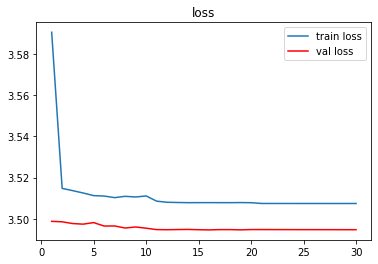

In [10]:
epochs = [i for i in range(1, len(history1.history['accuracy']) + 1)]
plt.plot(epochs, history1.history['loss'], label='train loss')
plt.plot(epochs, history1.history['val_loss'], 'r', label='val loss')
plt.title('loss')
plt.legend()
plt.show()

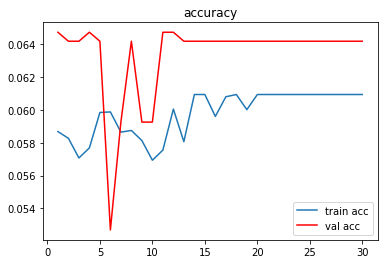

In [11]:
plt.plot(epochs, history1.history['accuracy'], label='train acc')
plt.plot(epochs, history1.history['val_accuracy'], 'r', label='val acc')
plt.title('accuracy')
plt.legend()
plt.show()

In [12]:
# 정확도를 높여보기 위해 dropout 적용하기
def cnn_model2():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(3, IMG_SIZE, IMG_SIZE), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

In [13]:
model2 = cnn_model2()

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [14]:
history2 = model2.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=nb_epoch,
          validation_split=0.2,
          shuffle=True,
          callbacks=[LearningRateScheduler(lr_schedule),
                    ModelCheckpoint('model.h5',save_best_only=True)]
            )

Epoch 1/30
914/914 [==============================] - 23s 24ms/step - loss: 1.4899 - accuracy: 0.5771 - val_loss: 0.2374 - val_accuracy: 0.9294 - lr: 0.0100
Epoch 2/30
914/914 [==============================] - 21s 23ms/step - loss: 0.2123 - accuracy: 0.9325 - val_loss: 0.1132 - val_accuracy: 0.9663 - lr: 0.0100
Epoch 3/30
914/914 [==============================] - 23s 25ms/step - loss: 0.1282 - accuracy: 0.9604 - val_loss: 0.0697 - val_accuracy: 0.9804 - lr: 0.0100
Epoch 4/30
914/914 [==============================] - 21s 23ms/step - loss: 0.0849 - accuracy: 0.9737 - val_loss: 0.0549 - val_accuracy: 0.9836 - lr: 0.0100
Epoch 5/30
914/914 [==============================] - 21s 22ms/step - loss: 0.0696 - accuracy: 0.9783 - val_loss: 0.0440 - val_accuracy: 0.9867 - lr: 0.0100
Epoch 6/30
914/914 [==============================] - 20s 22ms/step - loss: 0.0513 - accuracy: 0.9839 - val_loss: 0.0397 - val_accuracy: 0.9878 - lr: 0.0100
Epoch 7/30
914/914 [==============================] - 20s 

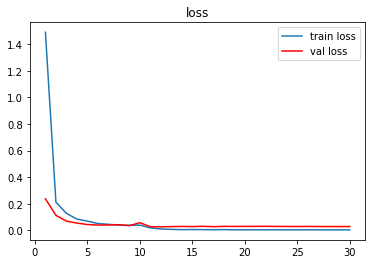

In [15]:
epochs = [i for i in range(1, len(history2.history['accuracy']) + 1)]
plt.plot(epochs, history2.history['loss'], label='train loss')
plt.plot(epochs, history2.history['val_loss'], 'r', label='val loss')
plt.title('loss')
plt.legend()
plt.show()

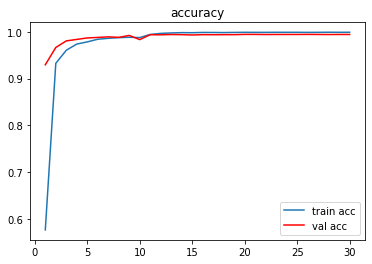

In [16]:
plt.plot(epochs, history2.history['accuracy'], label='train acc')
plt.plot(epochs, history2.history['val_accuracy'], 'r', label='val acc')
plt.title('accuracy')
plt.legend()
plt.show()

In [17]:
model.evaluate(X_test, y_test)

395/395 [==============================] - 5s 12ms/step - loss: 3.4824 - accuracy: 0.0594


[3.4823639392852783, 0.059382423758506775]

In [18]:
model2.evaluate(X_test, y_test)

395/395 [==============================] - 5s 11ms/step - loss: 0.2061 - accuracy: 0.9662


[0.2060539275407791, 0.9661915898323059]

In [19]:
X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(featurewise_center=False, 
                            featurewise_std_normalization=False, 
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.,)

datagen.fit(X_train_aug)

In [20]:
model3 = cnn_model()

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model3.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [21]:
history3 = model3.fit(datagen.flow(X_train_aug, y_train_aug, batch_size=batch_size),
                            epochs=nb_epoch,
                            validation_data=(X_val_aug, y_val_aug),
                            callbacks=[LearningRateScheduler(lr_schedule),
                                       ModelCheckpoint('model.h5',save_best_only=True)]
                           )

Epoch 1/30
914/914 [==============================] - 40s 43ms/step - loss: 2.0007 - accuracy: 0.4291 - val_loss: 0.2898 - val_accuracy: 0.9064 - lr: 0.0100
Epoch 2/30
914/914 [==============================] - 42s 46ms/step - loss: 0.3443 - accuracy: 0.8913 - val_loss: 0.0912 - val_accuracy: 0.9725 - lr: 0.0100
Epoch 3/30
914/914 [==============================] - 41s 45ms/step - loss: 0.1639 - accuracy: 0.9487 - val_loss: 0.0635 - val_accuracy: 0.9778 - lr: 0.0100
Epoch 4/30
914/914 [==============================] - 38s 42ms/step - loss: 0.1141 - accuracy: 0.9646 - val_loss: 0.0405 - val_accuracy: 0.9858 - lr: 0.0100
Epoch 5/30
914/914 [==============================] - 39s 42ms/step - loss: 0.0852 - accuracy: 0.9734 - val_loss: 0.0438 - val_accuracy: 0.9866 - lr: 0.0100
Epoch 6/30
914/914 [==============================] - 38s 41ms/step - loss: 0.0709 - accuracy: 0.9785 - val_loss: 0.0318 - val_accuracy: 0.9912 - lr: 0.0100
Epoch 7/30
914/914 [==============================] - 39s 

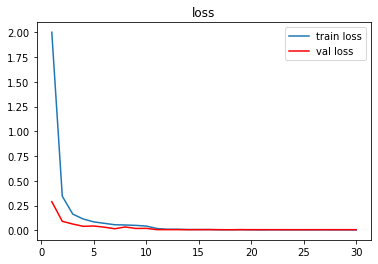

In [22]:
epochs = [i for i in range(1, len(history3.history['accuracy']) + 1)]
plt.plot(epochs, history3.history['loss'], label='train loss')
plt.plot(epochs, history3.history['val_loss'], 'r', label='val loss')
plt.title('loss')
plt.legend()
plt.show()

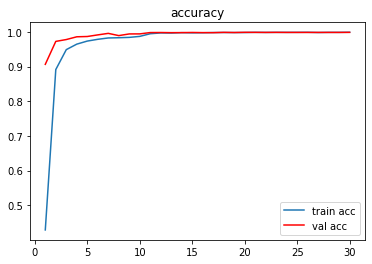

In [23]:
plt.plot(epochs, history3.history['accuracy'], label='train acc')
plt.plot(epochs, history3.history['val_accuracy'], 'r', label='val acc')
plt.title('accuracy')
plt.legend()
plt.show()

In [24]:
model3.evaluate(X_test, y_test)

395/395 [==============================] - 4s 9ms/step - loss: 0.0994 - accuracy: 0.9816


[0.0994342640042305, 0.9815518856048584]

In [25]:
model4 = cnn_model2()

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model4.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [26]:
history4 = model4.fit(datagen.flow(X_train_aug, y_train_aug, batch_size=batch_size),
                            epochs=nb_epoch,
                            validation_data=(X_val_aug, y_val_aug),
                            callbacks=[LearningRateScheduler(lr_schedule),
                                       ModelCheckpoint('model.h5',save_best_only=True)]
                           )

Epoch 1/30
914/914 [==============================] - 41s 44ms/step - loss: 2.2278 - accuracy: 0.3573 - val_loss: 0.6053 - val_accuracy: 0.8204 - lr: 0.0100
Epoch 2/30
914/914 [==============================] - 40s 43ms/step - loss: 0.6938 - accuracy: 0.7800 - val_loss: 0.1470 - val_accuracy: 0.9540 - lr: 0.0100
Epoch 3/30
914/914 [==============================] - 39s 42ms/step - loss: 0.3369 - accuracy: 0.8935 - val_loss: 0.0669 - val_accuracy: 0.9778 - lr: 0.0100
Epoch 4/30
914/914 [==============================] - 38s 42ms/step - loss: 0.2228 - accuracy: 0.9303 - val_loss: 0.0533 - val_accuracy: 0.9830 - lr: 0.0100
Epoch 5/30
914/914 [==============================] - 37s 41ms/step - loss: 0.1681 - accuracy: 0.9470 - val_loss: 0.0355 - val_accuracy: 0.9900 - lr: 0.0100
Epoch 6/30
914/914 [==============================] - 39s 43ms/step - loss: 0.1408 - accuracy: 0.9560 - val_loss: 0.0278 - val_accuracy: 0.9908 - lr: 0.0100
Epoch 7/30
914/914 [==============================] - 38s 

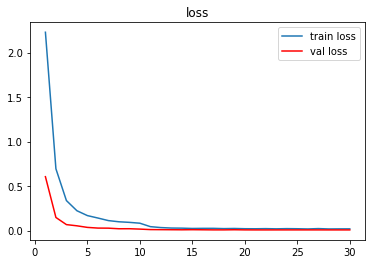

In [27]:
epochs = [i for i in range(1, len(history4.history['accuracy']) + 1)]
plt.plot(epochs, history4.history['loss'], label='train loss')
plt.plot(epochs, history4.history['val_loss'], 'r', label='val loss')
plt.title('loss')
plt.legend()
plt.show()

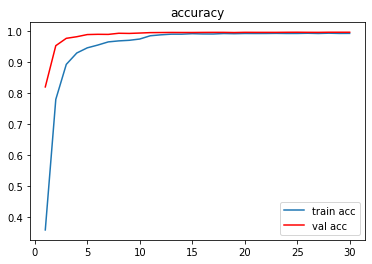

In [28]:
plt.plot(epochs, history4.history['accuracy'], label='train acc')
plt.plot(epochs, history4.history['val_accuracy'], 'r', label='val acc')
plt.title('accuracy')
plt.legend()
plt.show()

In [29]:
model4.evaluate(X_test, y_test)

395/395 [==============================] - 4s 9ms/step - loss: 0.0619 - accuracy: 0.9865


[0.061851780861616135, 0.98646080493927]

In [87]:
a = model4.predict(X_test)

In [89]:
a[0]

array([7.8249743e-21, 9.6767546e-21, 5.8061324e-23, 1.4538463e-18,
       2.0653408e-24, 4.8968071e-18, 1.8969804e-21, 1.5305731e-11,
       7.7526965e-18, 1.1379129e-12, 8.4136173e-24, 3.6959495e-19,
       3.1551697e-26, 9.9805746e-29, 4.7952886e-24, 1.9483252e-21,
       1.0000000e+00, 2.1807036e-23, 6.4403483e-31, 1.0088947e-27,
       3.2200430e-24, 8.6341489e-27, 5.2482220e-32, 2.6026365e-28,
       8.8147926e-27, 4.1254276e-26, 1.3668714e-27, 1.9859062e-26,
       1.8366788e-24, 7.5116685e-28, 1.8583300e-23, 1.6539913e-33,
       1.1735710e-19, 2.0197026e-21, 2.5675164e-24, 2.7687121e-24,
       1.5534260e-25, 6.4027637e-26, 8.4377389e-28, 1.6107331e-28,
       9.0370573e-27, 1.9812266e-22, 3.6654830e-18], dtype=float32)

In [30]:
from PIL import Image
import cv2
import os

In [48]:
# 한국 교통표지 이미지를 X_test_korea로 가져오기
root_dir_2 = '/content/drive/MyDrive/korean_traffic_sign/'
X_test_korea = []

images = os.listdir(root_dir_2)
print(images)

for image in images:
    im = Image.open(root_dir_2 + image)
    im2 = np.asarray(im)
    im3 = preprocess_img(im2)
    X_test_korea.append(np.asarray(im3))

X_test_korea = np.array(X_test_korea, dtype='float32')

['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg', '76.jpg', '77.jpg', '78.jpg', '79.jpg', '80.jpg', '81.jpg', '82.jpg', '83.jpg', '84.jpg', '85.jpg', '86.jpg', '87.jpg', '88.jpg', '89.jpg', '90.jpg', '91.jpg', '92.jpg', '93.jpg', '94.jpg', '95.jpg', '96.jpg', '97.jpg', '98.jpg', '99.jpg', '100.jpg'

In [49]:
X_test_korea.shape

(103, 3, 48, 48)

In [83]:
# 한국 표지판을 정확도가 제일 높은 독일 표지판 예측 모델에 넣어 결과 확인
y_pred = model4.predict(X_test_korea, batch_size=32)

In [82]:
# 독일 표지판의 레이블
label_map = {
    0: '20_speed',
    1: '30_speed',
    2: '50_speed',
    3: '60_speed',
    4: '70_speed',
    5: '80_speed',
    6: '80_lifted',
    7: '100_speed',
    8: '120_speed',
    9: 'no_overtaking_general',
    10: 'no_overtaking_trucks',
    11: 'right_of_way_crossing',
    12: 'right_of_way_general',
    13: 'give_way',
    14: 'stop',
    15: 'no_way_general',
    16: 'no_way_trucks',
    17: 'no_way_one_way',
    18: 'attention_general',
    19: 'attention_left_turn',
    20: 'attention_right_turn',
    21: 'attention_curvy',
    22: 'attention_bumpers',
    23: 'attention_slippery',
    24: 'attention_bottleneck',
    25: 'attention_construction',
    26: 'attention_traffic_light',
    27: 'attention_pedestrian',
    28: 'attention_children',
    29: 'attention_bikes',
    30: 'attention_snowflake',
    31: 'attention_deer',
    32: 'lifted_general',
    33: 'turn_right',
    34: 'turn_left',
    35: 'turn_straight',
    36: 'turn_straight_right',
    37: 'turn_straight_left',
    38: 'turn_right_down',
    39: 'turn_left_down',
    40: 'turn_circle',
    41: 'lifted_no_overtaking_general',
    42: 'lifted_no_overtaking_trucks'
}

In [84]:
# 한국 표지판을 모델이 예측했을 때, 바로 위 레이블 중에 index로 예측하는지 보기 위해 함수 만들기

def highest(arr):
  return np.where(arr == np.amax(arr))

In [85]:
y_pred_indexes = []
for i in range(len(X_test_korea)):
  y_pred_indexes.append(highest(y_pred[i])[0][0])

In [92]:
# 0~102번 번호를 붙인 한국 표지판을 다음과 같은 독일 표지판의 레이블로 예측하고 있음.
print(y_pred_indexes)

[29, 29, 29, 29, 29, 29, 29, 29, 29, 25, 29, 29, 29, 29, 29, 12, 12, 29, 29, 29, 29, 29, 29, 29, 26, 29, 29, 29, 22, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 15, 16, 16, 9, 3, 15, 16, 15, 14, 7, 42, 4, 1, 15, 33, 34, 3, 1, 16, 2, 2, 1, 13, 14, 13, 15, 12, 34, 38, 34, 40, 35, 33, 34, 36, 37, 34, 36, 40, 35, 38, 39, 38, 7, 34, 38, 39, 5, 34, 37, 38, 34, 38, 40, 7, 7, 35, 40, 38, 38, 35, 34]


In [98]:
y_pred_indexes[87]

39